## Experimenting with various forecasting approaches for supply chain management

#### Dataset
https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting



In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
import xgboost as xgb

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets

center = pd.read_csv("fulfilment_center_info.csv")
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [3]:
meal = pd.read_csv("meal_info.csv")
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [4]:
train = pd.read_csv("train.csv")
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
test = pd.read_csv("test.csv")
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [6]:
# Join the DataFrames on 'meal_id'
df = pd.merge(center, train, on='center_id', how='inner')

df_train = pd.merge(df, meal, on='meal_id', how='inner')

df_train.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,11,679,56,TYPE_A,3.7,1103215,1,1885,136.83,136.83,0,0,959,Beverages,Thai
1,11,679,56,TYPE_A,3.7,1091356,2,1885,133.86,135.86,0,0,1054,Beverages,Thai
2,11,679,56,TYPE_A,3.7,1195933,3,1885,135.86,133.86,0,0,891,Beverages,Thai
3,11,679,56,TYPE_A,3.7,1425602,4,1885,134.86,135.86,0,0,1107,Beverages,Thai
4,11,679,56,TYPE_A,3.7,1249127,5,1885,146.53,146.53,0,0,919,Beverages,Thai


In [7]:
# Join the DataFrames on 'meal_id'
df = pd.merge(center, test, on='center_id', how='inner')

df_test = pd.merge(df, meal, on='meal_id', how='inner')

df_test.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine
0,11,679,56,TYPE_A,3.7,1098228,146,1885,158.17,157.17,0,0,Beverages,Thai
1,11,679,56,TYPE_A,3.7,1080847,147,1885,158.14,158.14,0,0,Beverages,Thai
2,11,679,56,TYPE_A,3.7,1064602,148,1885,157.17,158.17,0,0,Beverages,Thai
3,11,679,56,TYPE_A,3.7,1093227,149,1885,157.17,158.17,0,0,Beverages,Thai
4,11,679,56,TYPE_A,3.7,1177861,150,1885,159.14,158.14,0,0,Beverages,Thai


### Explore column counts and create date column

In [8]:
list(df.columns)

['center_id',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'id',
 'week',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured']

In [9]:
count = center['region_code'].value_counts()
print(count)

56    30
34    21
77    17
85     5
23     1
71     1
35     1
93     1
Name: region_code, dtype: int64


In [10]:
count = center['center_type'].value_counts()
print(count)

TYPE_A    43
TYPE_C    19
TYPE_B    15
Name: center_type, dtype: int64


In [11]:
count = meal['meal_id'].nunique()
print(count)

51


In [12]:
count = meal['category'].value_counts()
print(count)

Beverages       12
Extras           3
Soup             3
Other Snacks     3
Salad            3
Rice Bowl        3
Starters         3
Sandwich         3
Pasta            3
Desert           3
Biryani          3
Pizza            3
Fish             3
Seafood          3
Name: category, dtype: int64


In [13]:
df_train.dtypes

center_id                  int64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
id                         int64
week                       int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
category                  object
cuisine                   object
dtype: object

In [14]:
df_test['week'].max()

155

In [15]:
import pandas as pd

# Assuming df_train exists and has a 'week' column with values 1-145

# Generate the weekly date range starting from January 1, 2018, for 145 weeks
start_date = '2018-01-01'
periods = 145  # Total number of weeks
frequency = 'W'  # Weekly frequency

date_series = pd.date_range(start=start_date, periods=periods, freq=frequency)

# Create a mapping from week numbers to dates
week_to_date_map = {week: date for week, date in zip(range(1, 146), date_series)}

# Map the 'week' column to dates using the map created
df_train['Date'] = df_train['week'].map(week_to_date_map)

# Now df_train has a new column 'Week_Start_Date' corresponding to the 'week' column



In [16]:
df_train['month'] = df_train['Date'].dt.month
df_train['year'] = df_train['Date'].dt.year

In [17]:
df_train.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,Date,month,year
0,11,679,56,TYPE_A,3.7,1103215,1,1885,136.83,136.83,0,0,959,Beverages,Thai,2018-01-07,1,2018
1,11,679,56,TYPE_A,3.7,1091356,2,1885,133.86,135.86,0,0,1054,Beverages,Thai,2018-01-14,1,2018
2,11,679,56,TYPE_A,3.7,1195933,3,1885,135.86,133.86,0,0,891,Beverages,Thai,2018-01-21,1,2018
3,11,679,56,TYPE_A,3.7,1425602,4,1885,134.86,135.86,0,0,1107,Beverages,Thai,2018-01-28,1,2018
4,11,679,56,TYPE_A,3.7,1249127,5,1885,146.53,146.53,0,0,919,Beverages,Thai,2018-02-04,2,2018


In [18]:
df_train['Date'].max()

Timestamp('2020-10-11 00:00:00')

In [19]:
import pandas as pd

# Assuming df_test exists and has a 'week' column with values 146-155

# Generate the weekly date range starting from October 12, 2020, for 10 weeks
start_date = '2020-10-12'
periods = 145  # Total number of weeks
frequency = 'W'  # Weekly frequency

date_series = pd.date_range(start=start_date, periods=periods, freq=frequency)

# Create a mapping from week numbers to dates
week_to_date_map = {week: date for week, date in zip(range(146, 156), date_series)}

# Map the 'week' column to dates using the map created
df_test['Date'] = df_test['week'].map(week_to_date_map)

# Now df_train has a new column 'Week_Start_Date' corresponding to the 'week' column


In [20]:
df_test['month'] = df_test['Date'].dt.month
df_test['year'] = df_test['Date'].dt.year

In [21]:
df_test.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,Date,month,year
0,11,679,56,TYPE_A,3.7,1098228,146,1885,158.17,157.17,0,0,Beverages,Thai,2020-10-18,10,2020
1,11,679,56,TYPE_A,3.7,1080847,147,1885,158.14,158.14,0,0,Beverages,Thai,2020-10-25,10,2020
2,11,679,56,TYPE_A,3.7,1064602,148,1885,157.17,158.17,0,0,Beverages,Thai,2020-11-01,11,2020
3,11,679,56,TYPE_A,3.7,1093227,149,1885,157.17,158.17,0,0,Beverages,Thai,2020-11-08,11,2020
4,11,679,56,TYPE_A,3.7,1177861,150,1885,159.14,158.14,0,0,Beverages,Thai,2020-11-15,11,2020


In [22]:
df_test['Date'].max()

Timestamp('2020-12-20 00:00:00')

In [23]:
# import the library
import dtale

# open the analysis in browser to explore the data
dtale.show(df_train).open_browser()

### Conduct Exploratory Data Analysis (EDA) based on train set and feature engineering

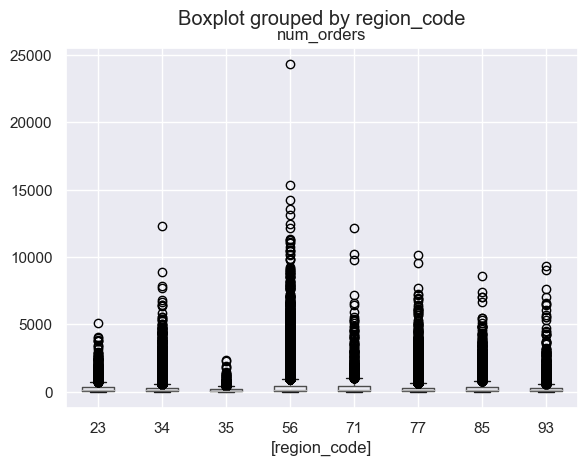

In [24]:
df_train[['num_orders','region_code']].boxplot(by='region_code',grid=True);

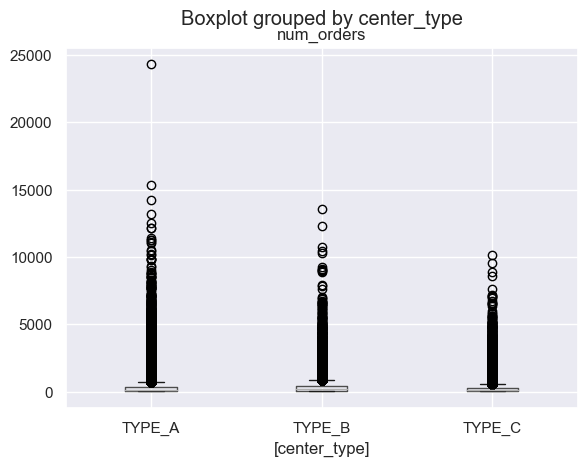

In [25]:
df_train[['num_orders','center_type']].boxplot(by='center_type',grid=True);

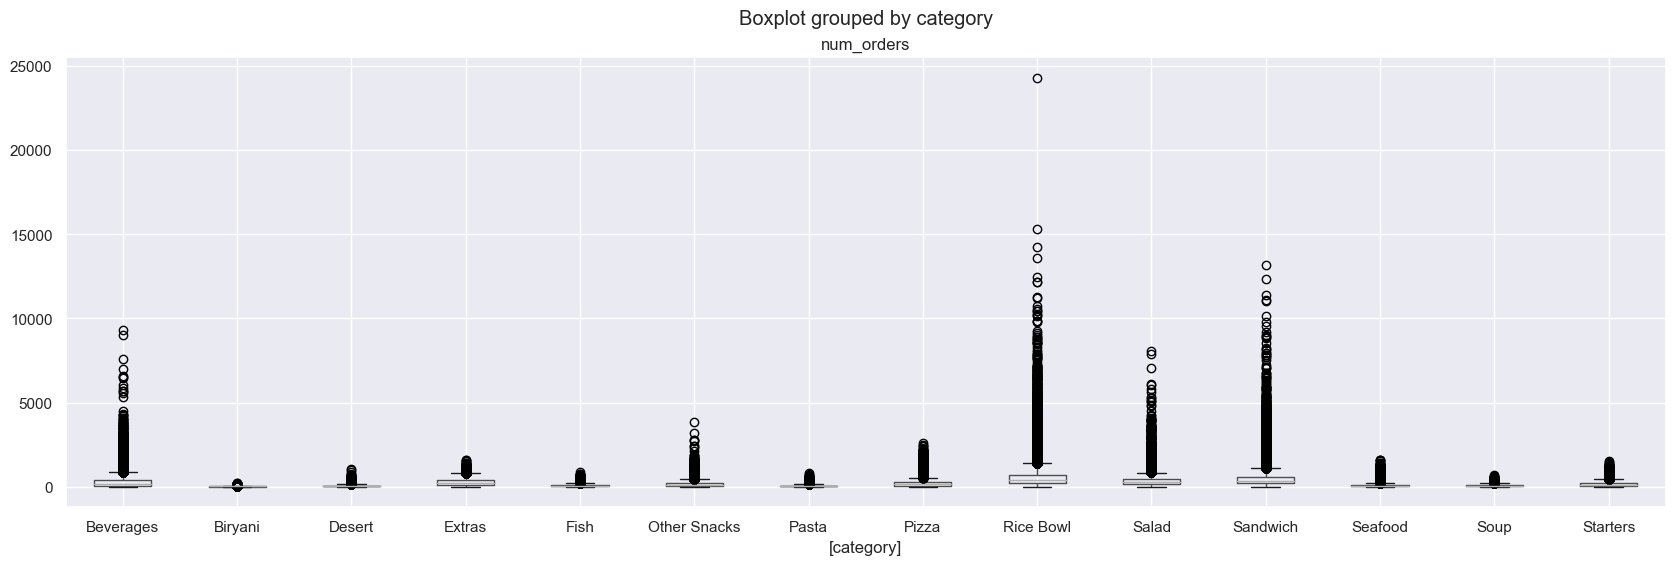

In [26]:
df_train[['num_orders','category']].boxplot(by='category',grid=True, figsize=(20,6));

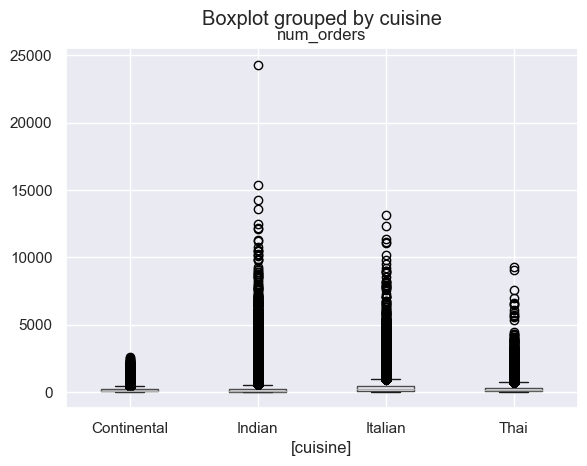

In [27]:
df_train[['num_orders','cuisine']].boxplot(by='cuisine',grid=True);

In [28]:
# Calculating a price discount feature

df_train['discount'] = (df_train['checkout_price'] - df_train['base_price']) / df_train['base_price'] * 100

In [29]:
import pandas as pd

# Group df_train by 'meal_id' and get descriptive statistics for 'num_orders'
descriptive_stats = df_train.groupby('meal_id')['num_orders'].describe()

print(descriptive_stats)


           count        mean          std   min     25%    50%      75%  \
meal_id                                                                   
1062     11137.0  423.165574   245.955526  13.0  256.00  366.0   539.00   
1109     11134.0  571.921412   526.852795  13.0  258.00  431.0   701.00   
1198      4206.0  242.101759   191.285165  13.0  107.00  188.0   334.00   
1207     10806.0  166.653341   144.606583  13.0   80.00  134.0   204.00   
1216      9695.0   55.034966    43.941466  13.0   26.00   42.0    69.00   
1230     10746.0  171.595850   148.641426  13.0   69.00  135.0   216.00   
1247      7184.0   32.279649    22.600579  13.0   14.00   27.0    41.00   
1248      9939.0   88.011872    98.923101  13.0   40.00   55.0   107.00   
1311      4682.0  318.171935   256.900863  13.0  135.00  231.0   431.75   
1438      4385.0   90.098974    74.394081  13.0   41.00   69.0   121.00   
1445      9727.0  108.894932   145.703181  13.0   28.00   67.0   109.00   
1525      9359.0  183.713

In [30]:
import pandas as pd

# Grouping by meal_id and summing the sales
meal_sales = df_train.groupby('meal_id')['num_orders'].sum()

# Calculating total sales
total_sales = meal_sales.sum()

# Calculating share of each meal's sales in total sales
meal_shares = meal_sales / total_sales

print(meal_shares)


meal_id
1062    0.039419
1109    0.053261
1198    0.008517
1207    0.015063
1216    0.004463
1230    0.015423
1247    0.001940
1248    0.007317
1311    0.012460
1438    0.003305
1445    0.008860
1525    0.014381
1543    0.006616
1558    0.014628
1571    0.003387
1727    0.039613
1754    0.057027
1770    0.001595
1778    0.027672
1803    0.012354
1847    0.002322
1878    0.012898
1885    0.069809
1902    0.001750
1962    0.027065
1971    0.047915
1993    0.055679
2104    0.001338
2126    0.004998
2139    0.003187
2290    0.081721
2304    0.005097
2306    0.004237
2322    0.019223
2444    0.007884
2490    0.031024
2492    0.004519
2494    0.003069
2539    0.027054
2569    0.027890
2577    0.008546
2581    0.020066
2631    0.009118
2640    0.017442
2664    0.032627
2704    0.013474
2707    0.049623
2760    0.012011
2826    0.042575
2867    0.005971
2956    0.002568
Name: num_orders, dtype: float64


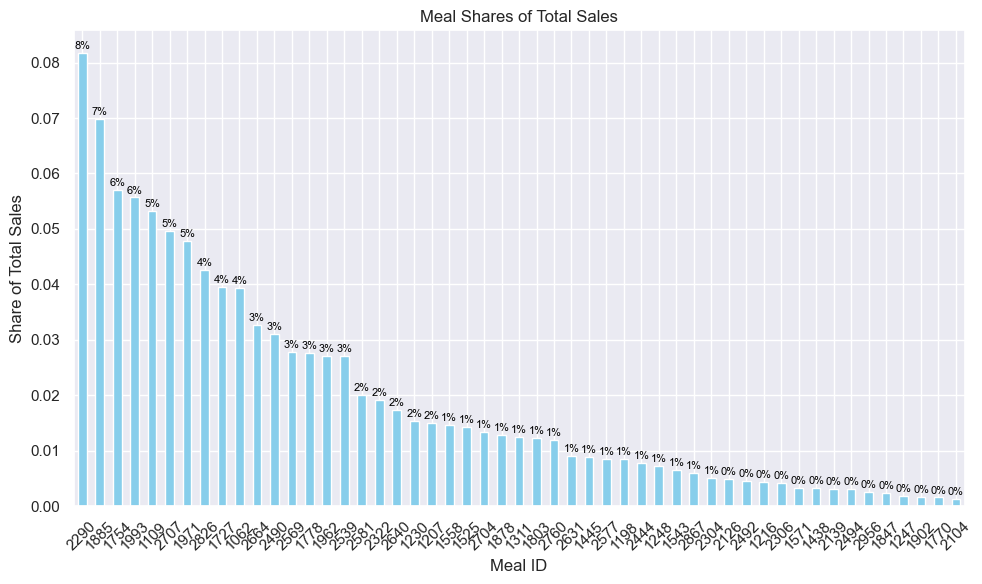

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train has columns 'meal_id' and 'num_orders'
# Grouping by meal_id and summing the sales
meal_sales = df_train.groupby('meal_id')['num_orders'].sum()

# Calculating total sales
total_sales = meal_sales.sum()

# Calculating share of each meal's sales in total sales
meal_shares = meal_sales / total_sales

# Sorting meal shares in descending order
meal_shares_sorted = meal_shares.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
ax = meal_shares_sorted.plot(kind='bar', color='skyblue')
plt.title('Meal Shares of Total Sales')
plt.xlabel('Meal ID')
plt.ylabel('Share of Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding percent share at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [32]:
select = df_train[['op_area',
 'num_orders',
 'checkout_price',
 'base_price',
 'discount',
 'emailer_for_promotion',
 'homepage_featured']]

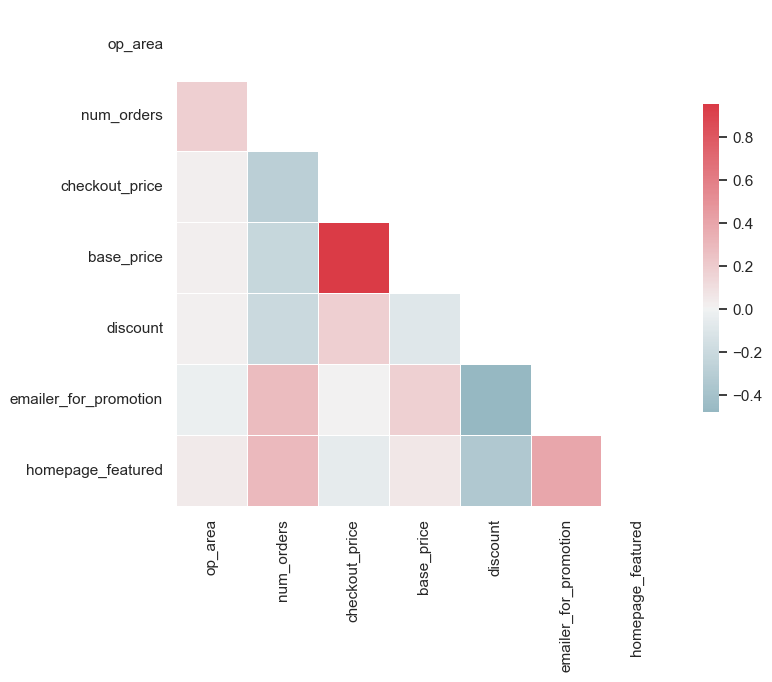

In [33]:
# Creating heatmap

corr = select.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(style="white")
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [34]:
sns.set(style="darkgrid")
#function for plotting distribution of quantitiative variables 
def plot_distribution(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(df[col], bins=20, kde=True, ax=ax[0])
    sns.boxplot(x=df[col], ax=ax[1])
    plt.suptitle(col);

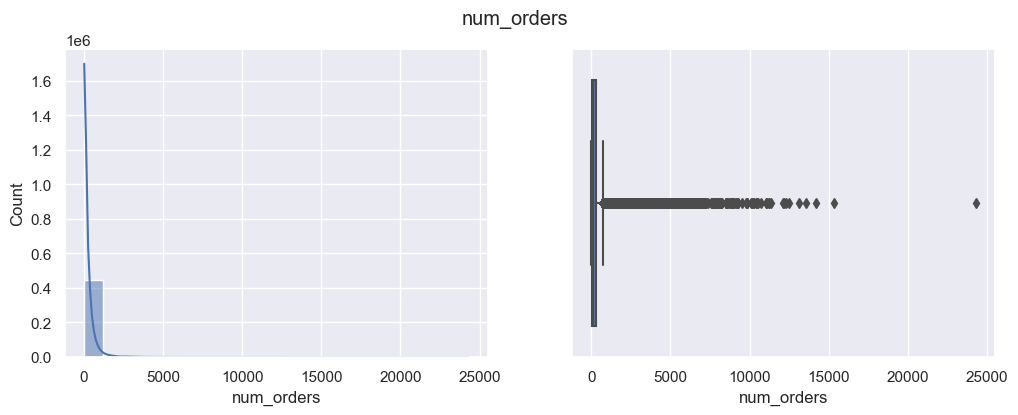

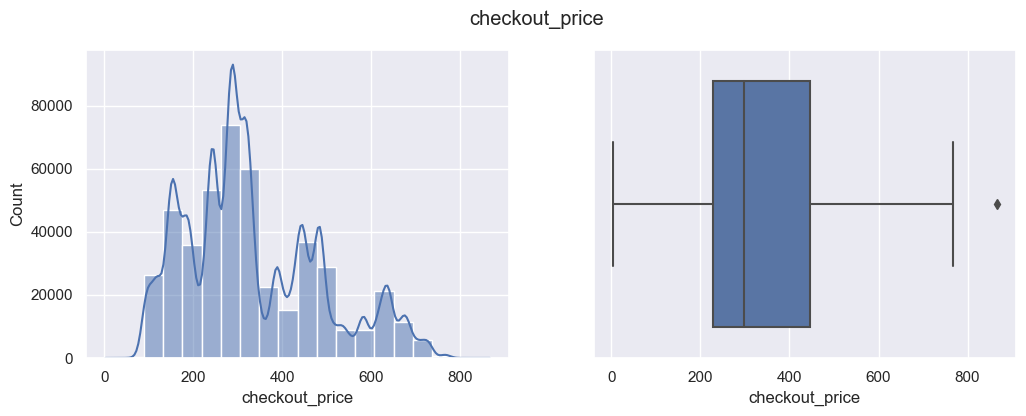

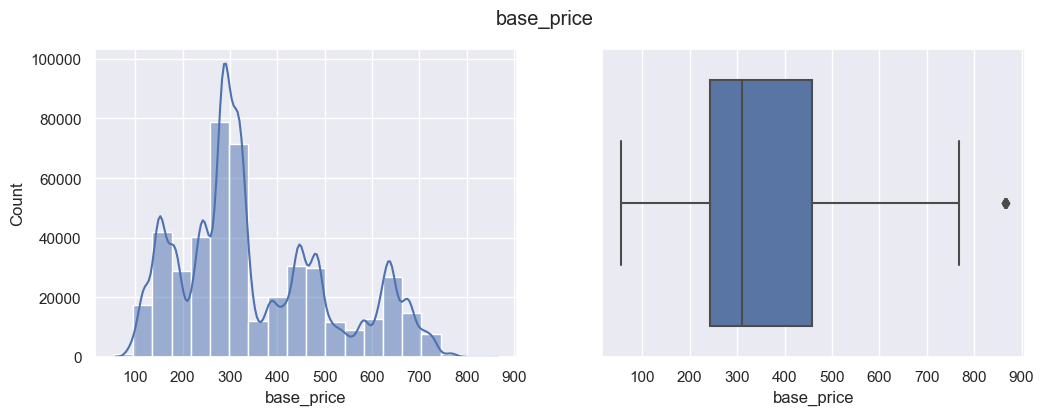

In [35]:
target_vars = ['num_orders','checkout_price','base_price']
for v in target_vars:
    plot_distribution(df_train, v)

In [36]:
# Let's reset the index to the order date so we can plot the sales in a time series fashion

df_train = df_train.set_index('Date')

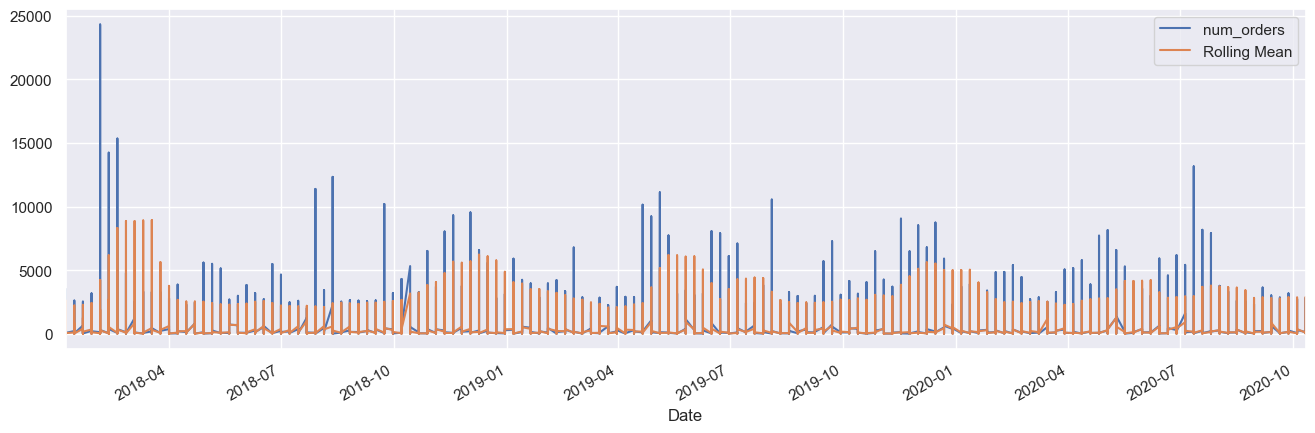

In [37]:
# Creating a chart to show the time series with rolling window based on weekly data

df_train['Rolling Mean'] = df_train['num_orders'].rolling(window=7).mean()
df_train[['num_orders','Rolling Mean']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

In [38]:
# The data is a bit messy, so maybe we can get a better result with monthly aggregated data

monthly_group = df_train.resample('MS')

monthly_df = monthly_group.agg({'num_orders': ['sum']})

monthly_df.head()

,num_orders
,sum
Date,
2018-01-01,3018136
2018-02-01,3751284
2018-03-01,2997552
2018-04-01,3376602
2018-05-01,3104603


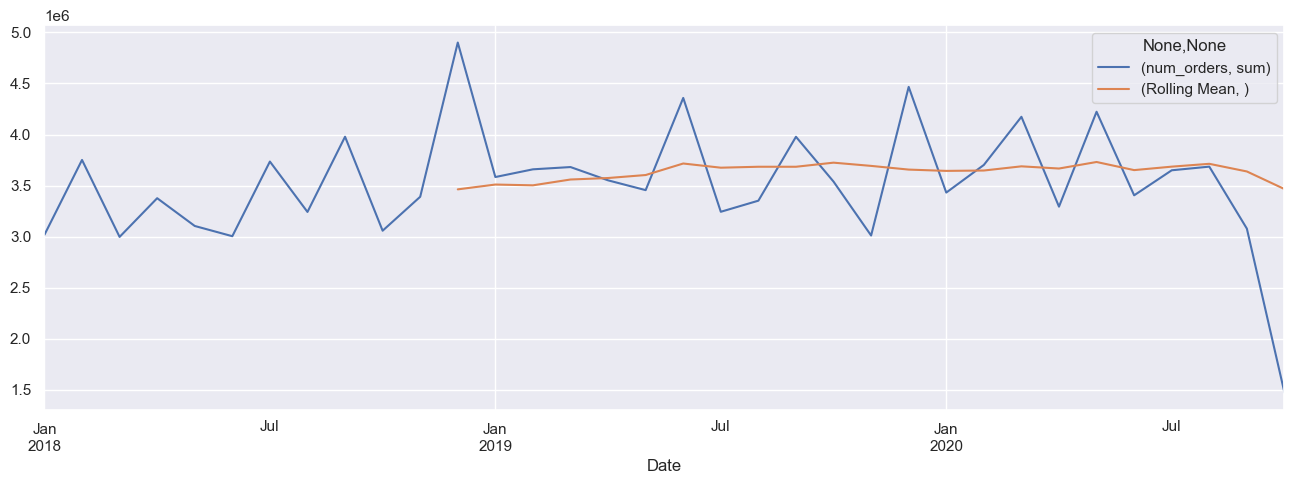

In [39]:
monthly_df['Rolling Mean'] = monthly_df['num_orders'].rolling(window=12).mean()
monthly_df[['num_orders','Rolling Mean']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

Why does there appear to be a big drop in sales when we aggregate to the montly level? Because we are including October 2020, which is not a complete month of data. We need to remove October 2020 from the series.

In [40]:
# Remove Oct 2020 from the training set and rerun rolling average

filtered_df = df_train[~((df_train['year'] == 2020) & (df_train['month'] == 10))]

In [41]:
# The data is a bit messy, so maybe we can get a better result with monthly aggregated data

monthly_group = filtered_df.resample('MS')

monthly_df = monthly_group.agg({'num_orders': ['sum']})

monthly_df.head()

,num_orders
,sum
Date,
2018-01-01,3018136
2018-02-01,3751284
2018-03-01,2997552
2018-04-01,3376602
2018-05-01,3104603


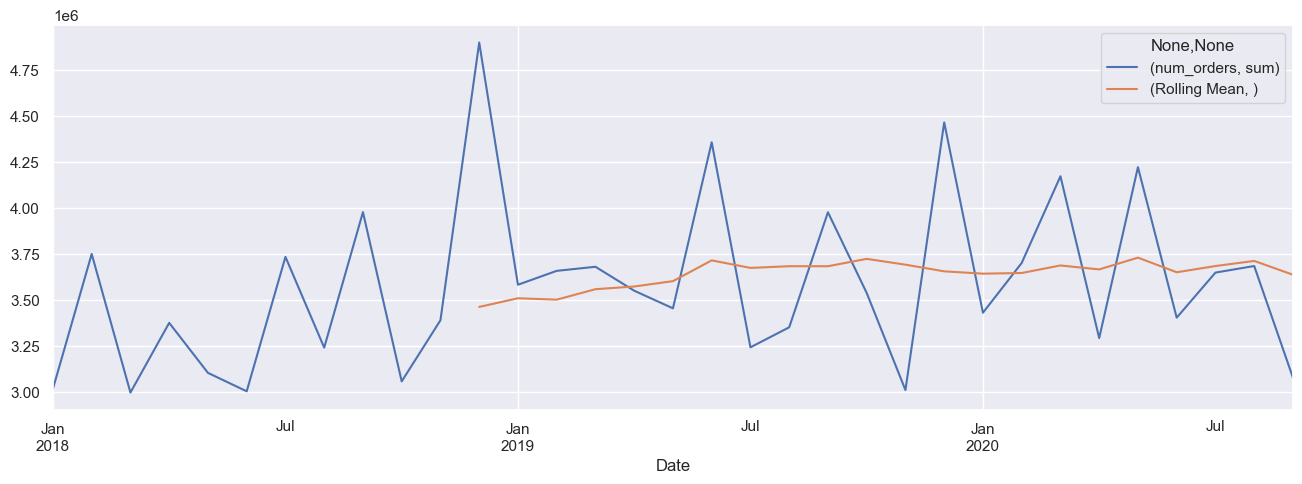

In [42]:
monthly_df['Rolling Mean'] = monthly_df['num_orders'].rolling(window=12).mean()
monthly_df[['num_orders','Rolling Mean']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

### EDA based on meal_id = 1207

In [43]:
sample = filtered_df[filtered_df['meal_id'] == 1207]
sample.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,month,year,discount,Rolling Mean
Date,,,,,,,,,,,,,,,,,,,
2018-01-07,11,679,56,TYPE_A,3.7,1277077,1,1207,315.25,353.08,0,1,446,Beverages,Continental,1,2018,-10.714286,771.285714
2018-01-14,11,679,56,TYPE_A,3.7,1106021,2,1207,322.04,323.04,0,0,230,Beverages,Continental,1,2018,-0.309559,688.428571
2018-01-21,11,679,56,TYPE_A,3.7,1333188,3,1207,324.98,323.04,1,0,230,Beverages,Continental,1,2018,0.600545,603.714286
2018-01-28,11,679,56,TYPE_A,3.7,1268751,4,1207,318.16,319.16,0,0,149,Beverages,Continental,1,2018,-0.313322,509.142857
2018-02-04,11,679,56,TYPE_A,3.7,1403388,5,1207,388.97,389.97,0,0,204,Beverages,Continental,2,2018,-0.256430,424.571429


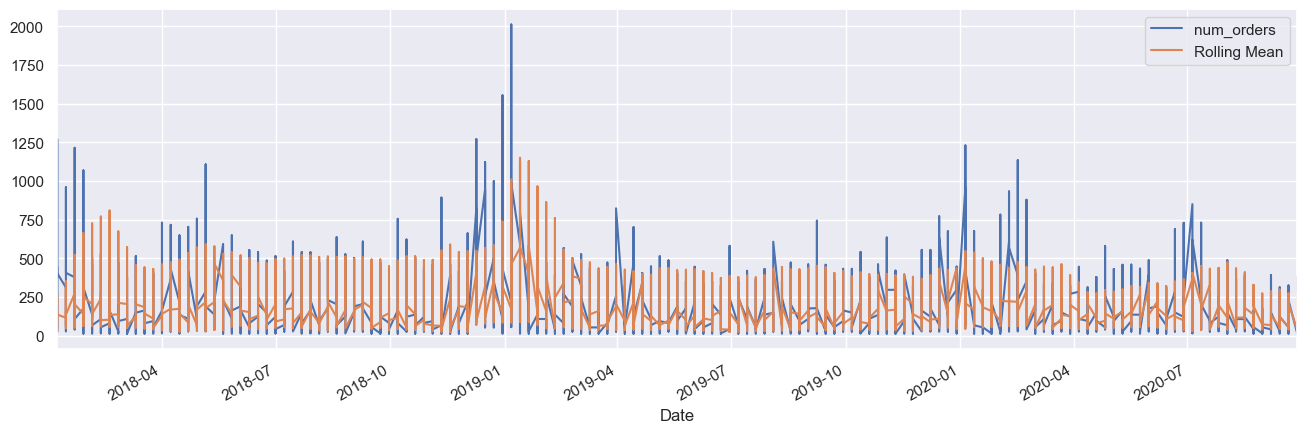

In [44]:
# Creating a chart to show the time series with rolling window

sample['Rolling Mean'] = sample['num_orders'].rolling(window=7).mean()
sample[['num_orders','Rolling Mean']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

In [45]:
monthly_group = sample.resample('MS')

monthly_df = monthly_group.agg({'num_orders': ['sum']})

monthly_df.head()

,num_orders
,sum
Date,
2018-01-01,77773
2018-02-01,43086
2018-03-01,38388
2018-04-01,85492
2018-05-01,51502


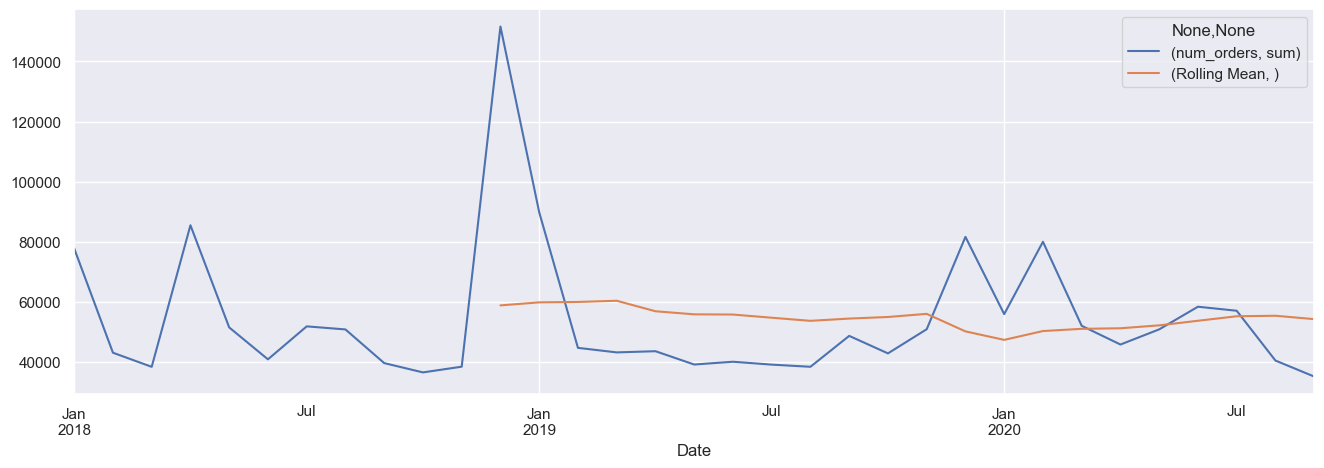

In [46]:
monthly_df['Rolling Mean'] = monthly_df['num_orders'].rolling(window=12).mean()
monthly_df[['num_orders','Rolling Mean']].plot(figsize=(16,5)).autoscale(axis='x',tight=True);

Although the series looks better aggregated to the monthly level, food has a shelf life and we probaby want to try to predict sales at the weekly level. Should we try to model at the weekly level or should we go ahead and model at the monthly level and create a weekly index to get weekly sales?

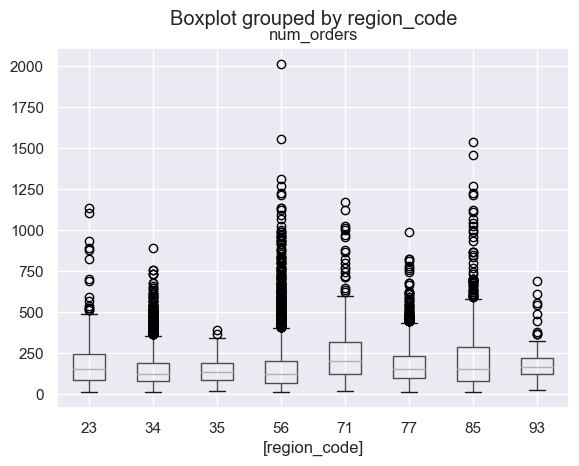

In [47]:
sample[['num_orders','region_code']].boxplot(by='region_code',grid=True);

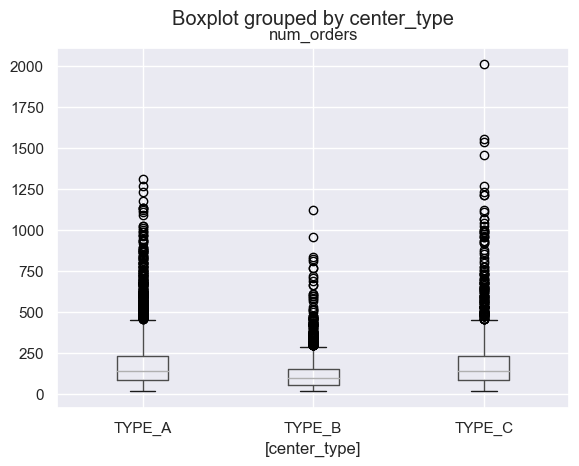

In [48]:
sample[['num_orders','center_type']].boxplot(by='center_type',grid=True);

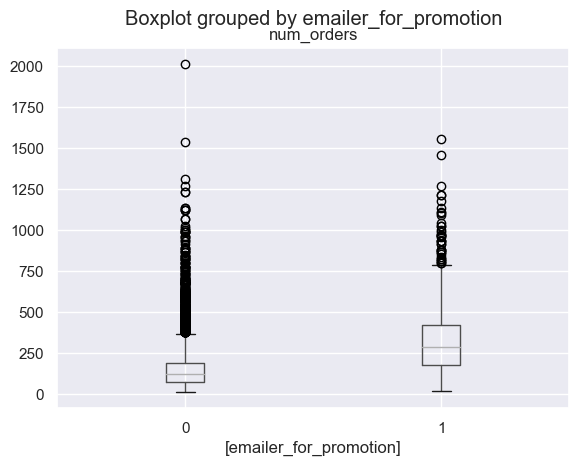

In [49]:
sample[['num_orders','emailer_for_promotion']].boxplot(by='emailer_for_promotion',grid=True);

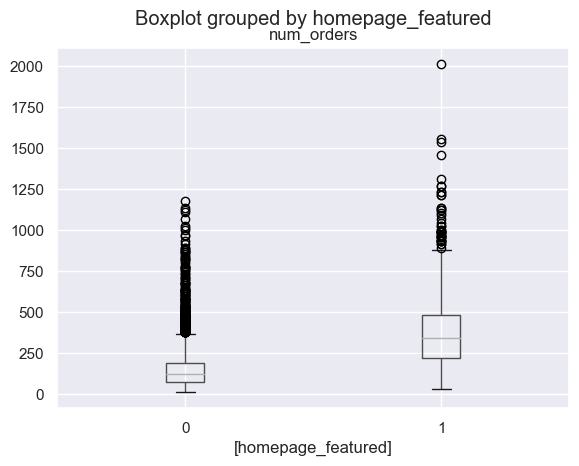

In [50]:
sample[['num_orders','homepage_featured']].boxplot(by='homepage_featured',grid=True);

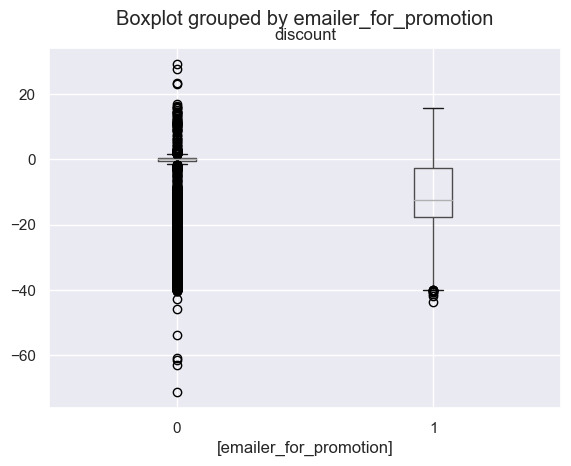

In [51]:
sample[['discount','emailer_for_promotion']].boxplot(by='emailer_for_promotion',grid=True);

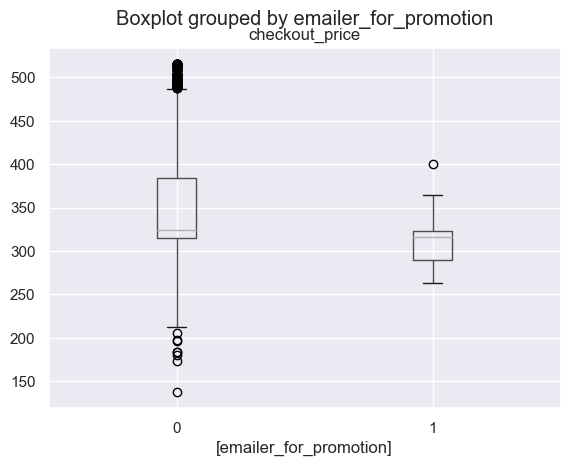

In [52]:
sample[['checkout_price','emailer_for_promotion']].boxplot(by='emailer_for_promotion',grid=True);

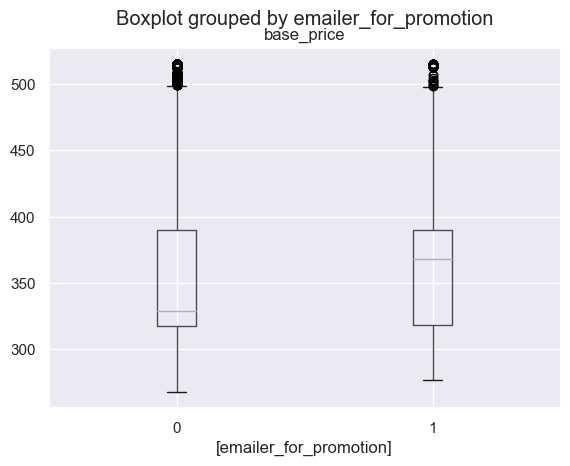

In [53]:
sample[['base_price','emailer_for_promotion']].boxplot(by='emailer_for_promotion',grid=True);

There are some fairly significant differences based on region and center type. Should we forecast at the aggregate level (top down) and then get lower level demand by calculating shares? 

In [54]:
select = sample[['op_area',
 'num_orders',
 'checkout_price',
 'base_price',
 'discount',
 'emailer_for_promotion',
 'homepage_featured']]

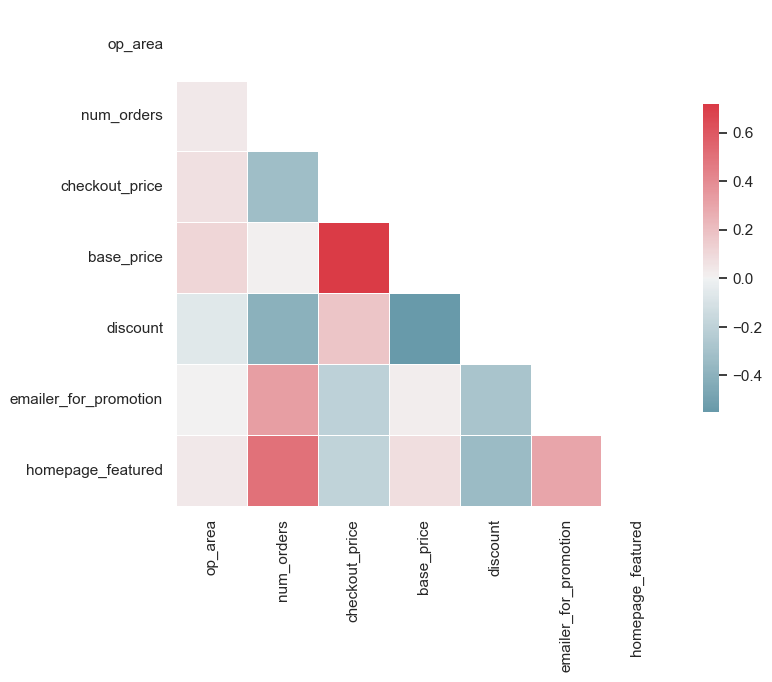

In [55]:
# Creating heatmap

corr = select.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(style="white")
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

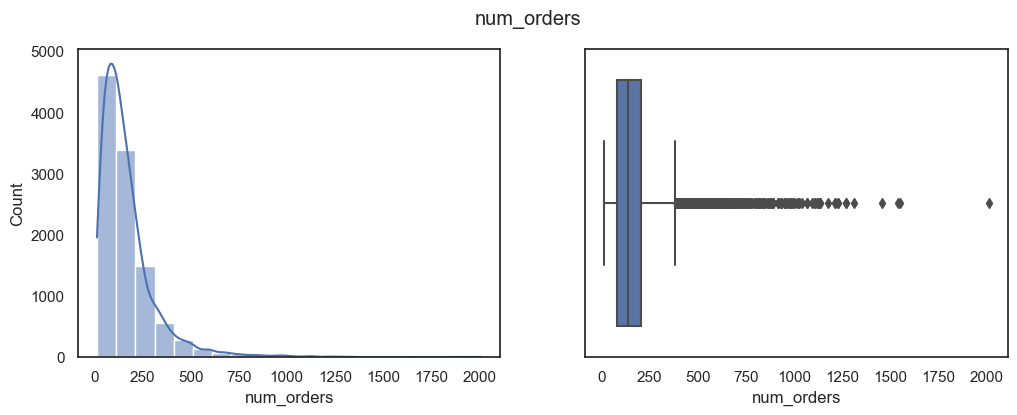

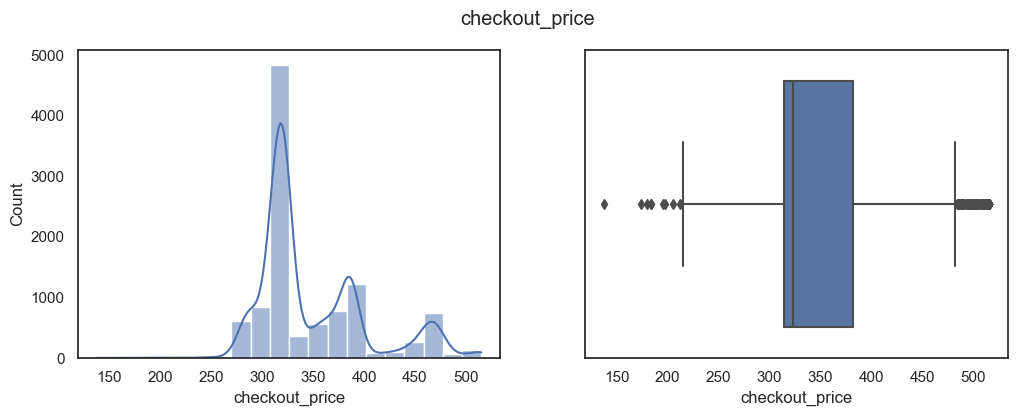

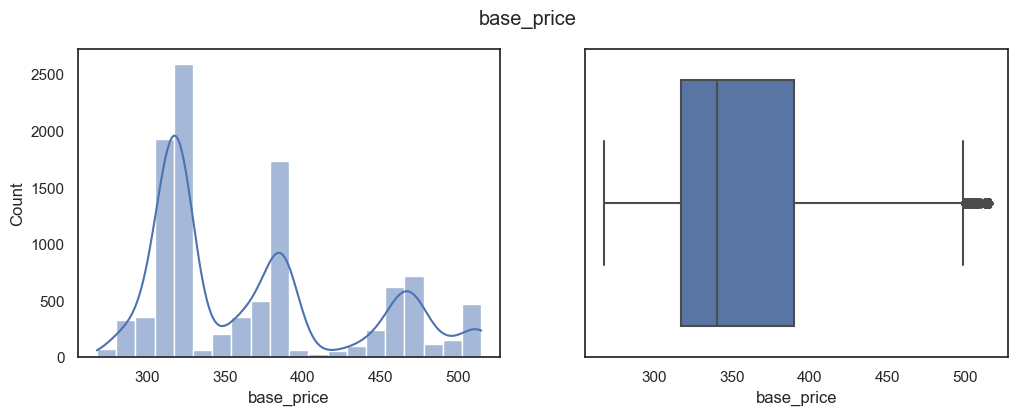

In [56]:
target_vars = ['num_orders','checkout_price','base_price']
for v in target_vars:
    plot_distribution(sample, v)

### Begin time series modeling

In [57]:
# Automate the augmented Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [58]:
adf_test(sample['num_orders'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.595269e+00
p-value                 1.986114e-16
# lags used             3.900000e+01
# observations          1.061300e+04
critical value (1%)    -3.430966e+00
critical value (5%)    -2.861812e+00
critical value (10%)   -2.566915e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


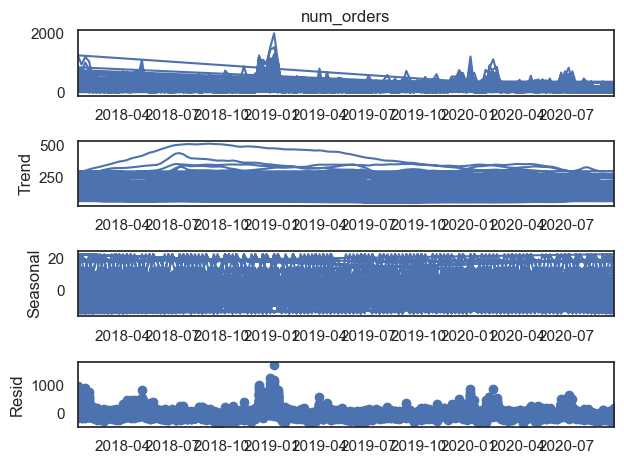

In [59]:
# Assuming your data is weekly and you're interested in annual seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sample['num_orders'], model='additive', period=52)
result.plot();

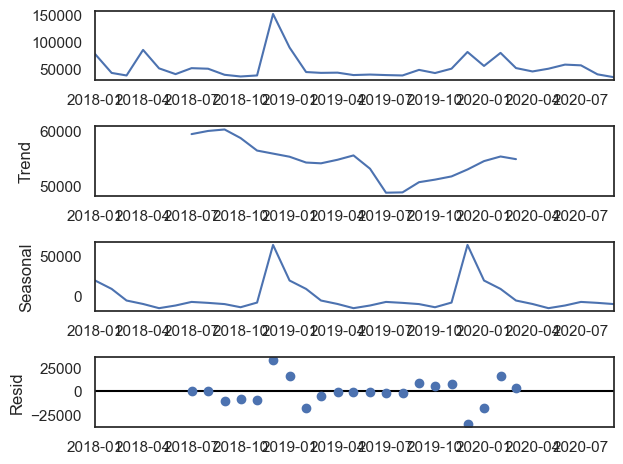

In [60]:
# Assuming your data is weekly and you're interested in annual seasonality
result = seasonal_decompose(monthly_df['num_orders'], model='additive', period=12)
result.plot();

The monthly series is much cleaner. Perhaps we should model at the monthly level and then create week indices to get to weekly demand volumes.

In [61]:
adf_test(monthly_df['num_orders'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.586939
p-value                  0.000137
# lags used              0.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [62]:
# Applying ARIMA model to get p and q. No d is needed since data is stationary.

monthly_df.sort_values('Date', inplace=True)

auto_arima(monthly_df['num_orders'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   33
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                -376.022
Date:                    Sat, 02 Mar 2024   AIC                            758.044
Time:                            15:43:49   BIC                            762.533
Sample:                        01-01-2018   HQIC                           759.554
                             - 09-01-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.406e+04   1.02e+04      5.297      0.000    3.41e+04    7.41e+04
ma.S.L12       0.4662      0.344      1.357      0.175      -0.207       1.140
sigma2      5.188e+08      0.063   8.29e+09      0.000    5.19e+08    5.19e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):               132.71
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             2.61
Prob(H) (two-sided):                  0.51   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.52e+26. Standard errors may be unstable.
"""

#### Split the data into train/test sets 
We can't use the test set given to us because it doesn't have data for num_orders, so we will split the training set into a train and test set

In [63]:
monthly_df.head()

,num_orders,Rolling Mean
,sum,
Date,,
2018-01-01,77773,NaN
2018-02-01,43086,NaN
2018-03-01,38388,NaN
2018-04-01,85492,NaN
2018-05-01,51502,NaN


In [64]:
# Set 3 months for forecasting
train = monthly_df.iloc[:30]
test = monthly_df.iloc[30:]

In [65]:
train.sort_values('Date', inplace=True)
test.sort_values('Date', inplace=True)

model = SARIMAX(train['num_orders'],order=(0,0,1),seasonal_order=(0,0,1,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21575D+01    |proj g|=  2.88688D-01

At iterate    5    f=  1.20968D+01    |proj g|=  1.21623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   1.067D-05   1.210D+01
  F =   12.096833977432624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                sum   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -362.905
Date:                            Sat, 02 Mar 2024   AIC                            731.810
Time:                                    15:43:49   BIC                            736.014
Sample:                                01-01-2018   HQIC                           733.155
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6531      0.620      1.053      0.292      -0.563       1.869
ma.S.L12       0.3746      0.520      0.721      0.471      -0.644       1.393
sigma2      3.177e+09   1.68e-10   1.89e+19      0.000    3.18e+09    3.18e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.56   Jarque-Bera (JB):                69.77
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             2.11
Prob(H) (two-sided):                  0.59   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [66]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(0,0,1),(0,0,1,12) Predictions')

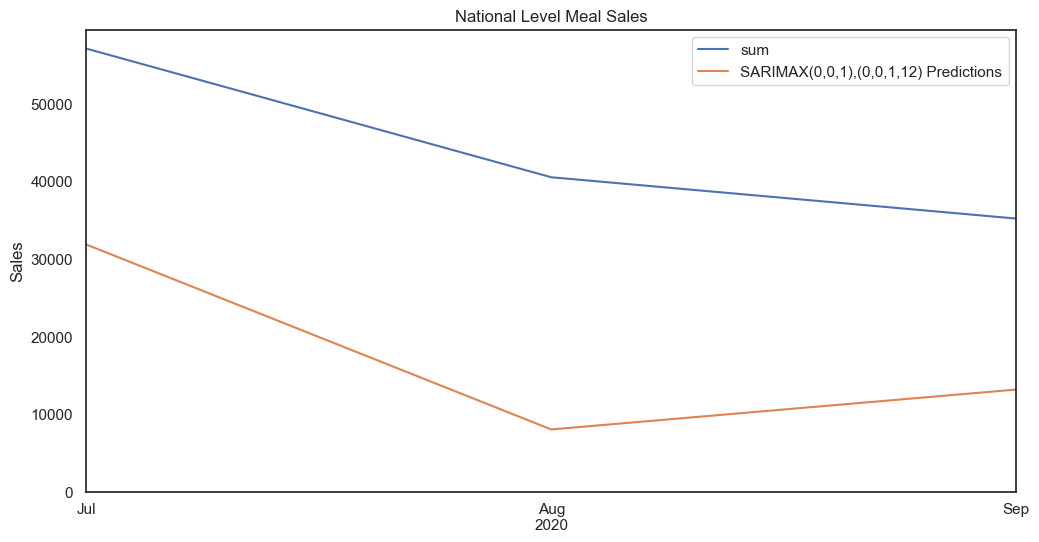

In [67]:
import matplotlib.pyplot as plt

title = 'National Level Meal Sales'
ylabel='Sales'
xlabel=''  # we don't really need a label here

ax = test['num_orders'].plot(legend=True, figsize=(12, 6), title=title)
predictions.plot(legend=True, ax=ax)  # Make sure predictions plot on the same axis
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Set y-axis to start at zero
ax.set_ylim(bottom=0)  # This automatically adjusts the upper limit as needed

plt.show();


#### Evaluating the national level model's performance at monthly level

In [68]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['num_orders'], predictions)
print(f'SARIMAX(0,0,1),(0,0,1,12) MSE Error: {error:11.10}')

SARIMAX(0,0,1),(0,0,1,12) MSE Error: 725590746.6


In [69]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual and forecast values from the DataFrame
actual_values = test['num_orders'].values
forecast_values = predictions

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")


MAPE: 62.37%


In [70]:
actual_values

array([[57050],
       [40475],
       [35156]])

In [71]:
forecast_values

2020-07-01    31813.696975
2020-08-01     7994.081213
2020-09-01    13135.755584
Freq: MS, Name: SARIMAX(0,0,1),(0,0,1,12) Predictions, dtype: float64

#### Weekly Model National Forecast

In [72]:
# Resample to weekly frequency, starting on Sundays by default
weekly_group = sample.resample('W')

# Aggregate data by summing up the 'num_orders' for each week
weekly_df = weekly_group.agg({'num_orders': ['sum']})

# Display the first few rows of the weekly aggregated data
weekly_df.head()

,num_orders
,sum
Date,
2018-01-07,20893
2018-01-14,19788
2018-01-21,17538
2018-01-28,19554
2018-02-04,12396


In [73]:
length = len(weekly_df)
print(length)

143


In [74]:
weekly_df.sort_values('Date', inplace=True)

In [75]:
# Set 3 months for forecasting
train = weekly_df.iloc[:131]
test = weekly_df.iloc[131:]

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'train' is your DataFrame and it has a column 'num_orders'
# For weekly data with yearly seasonality, s=52 (weeks in a year)
model = SARIMAX(train['num_orders'],
                order=(0, 0, 1),  # Non-seasonal order
                seasonal_order=(0, 0, 1, 52))  # Seasonal order with yearly seasonality for weekly data

results = model.fit()
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06538D+01    |proj g|=  1.59801D-01

At iterate    5    f=  1.06333D+01    |proj g|=  1.20809D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.650D-05   1.063D+01
  F =   10.633280412241792     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                                sum   No. Observations:                  131
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood               -1392.960
Date:                            Sat, 02 Mar 2024   AIC                           2791.919
Time:                                    15:43:49   BIC    

In [77]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(0,0,1),(0,0,1,12) Predictions')

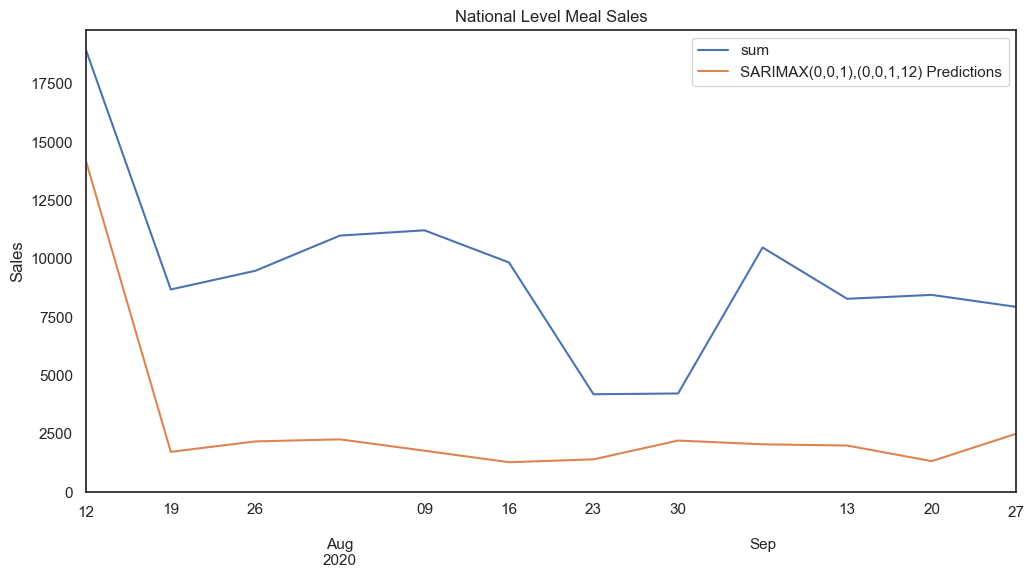

In [78]:
import matplotlib.pyplot as plt

title = 'National Level Meal Sales'
ylabel='Sales'
xlabel=''  # we don't really need a label here

ax = test['num_orders'].plot(legend=True, figsize=(12, 6), title=title)
predictions.plot(legend=True, ax=ax)  # Make sure predictions plot on the same axis
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Set y-axis to start at zero
ax.set_ylim(bottom=0)  # This automatically adjusts the upper limit as needed

plt.show();

#### Evaluate weekly level national model

In [79]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['num_orders'], predictions)
print(f'SARIMAX(0,0,1),(0,0,1,12) MSE Error: {error:11.10}')

SARIMAX(0,0,1),(0,0,1,12) MSE Error:  47132396.1


In [80]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual and forecast values from the DataFrame
actual_values = test['num_orders'].values
forecast_values = predictions

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")

MAPE: 71.33%


In [81]:
actual_values

array([[18908],
       [ 8684],
       [ 9484],
       [10991],
       [11218],
       [ 9841],
       [ 4196],
       [ 4229],
       [10482],
       [ 8284],
       [ 8452],
       [ 7938]])

In [82]:
forecast_values

2020-07-12    14146.187163
2020-07-19     1729.323671
2020-07-26     2175.204126
2020-08-02     2264.132064
2020-08-09     1778.085490
2020-08-16     1284.926870
2020-08-23     1407.040517
2020-08-30     2211.988492
2020-09-06     2051.773372
2020-09-13     1998.613853
2020-09-20     1330.598981
2020-09-27     2505.183833
Freq: W-SUN, Name: SARIMAX(0,0,1),(0,0,1,12) Predictions, dtype: float64

### Building models for each region_code

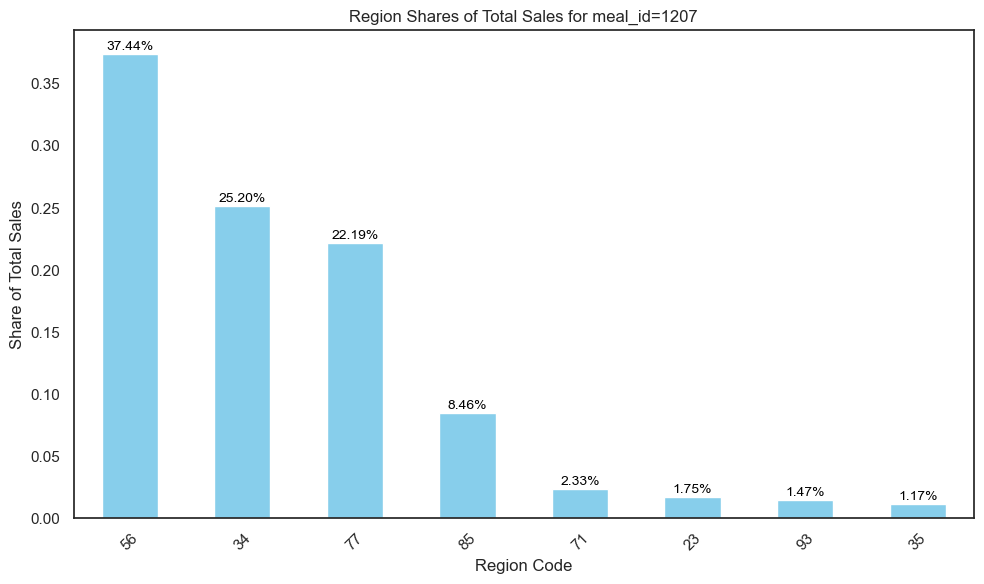

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataset for meal_id=1207
df_menu1207 = df_train[df_train['meal_id'] == 1207]

# Grouping by region_code and summing the sales
region_sales = df_menu1207.groupby('region_code')['num_orders'].sum()

# Calculating total sales
total_sales = region_sales.sum()

# Calculating share of each region's sales in total sales
region_shares = region_sales / total_sales

# Sorting region shares in descending order
region_shares_sorted = region_shares.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
ax = region_shares_sorted.plot(kind='bar', color='skyblue')
plt.title('Region Shares of Total Sales for meal_id=1207')
plt.xlabel('Region Code')
plt.ylabel('Share of Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding percent share at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [84]:
# Grouping by 'region_code' and creating separate DataFrames
for region_code, region_group in sample.groupby('region_code'):
    globals()[f'code{region_code}'] = region_group.copy()

#### Running model for Region 23

In [157]:
m_group = code23.resample('MS')

m_df = m_group.agg({'num_orders': ['sum']})

m_df.head()

,num_orders
,sum
Date,
2018-01-01,1230
2018-02-01,472
2018-03-01,312
2018-04-01,1705
2018-05-01,1172


In [158]:
m_df.sort_values('Date', inplace=True)

In [162]:
# Set 3 months for forecasting
train = m_df.iloc[:30]
test = m_df.iloc[30:]

In [169]:
model = SARIMAX(train['num_orders'],order=(0,0,1),seasonal_order=(0,0,1,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31887D+00    |proj g|=  3.05348D-01

At iterate    5    f=  8.25267D+00    |proj g|=  7.98866D-04

At iterate   10    f=  8.25251D+00    |proj g|=  6.80622D-03

At iterate   15    f=  8.23426D+00    |proj g|=  1.00031D-01

At iterate   20    f=  8.15693D+00    |proj g|=  1.81600D-02

At iterate   25    f=  8.15227D+00    |proj g|=  1.45878D-03

At iterate   30    f=  8.15188D+00    |proj g|=  3.46809D-03

At iterate   35    f=  8.15181D+00    |proj g|=  2.88978D-05

At iterate   40    f=  8.15180D+00    |proj g|=  2.17332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                sum   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -244.554
Date:                            Sun, 03 Mar 2024   AIC                            495.108
Time:                                    09:49:28   BIC                            499.311
Sample:                                01-01-2018   HQIC                           496.453
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4856      0.366      1.327      0.185      -0.232       1.203
ma.S.L12       0.9938      0.148      6.729      0.000       0.704       1.283
sigma2      4.274e+05   3.46e-07   1.24e+12      0.000    4.27e+05    4.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):                52.60
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.99
Prob(H) (two-sided):                  0.79   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.43e+27. Standard errors may be unstable.
"""

In [170]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(0,0,1),(0,0,1,12) Predictions')

In [171]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual and forecast values from the DataFrame
actual_values = test['num_orders'].values
forecast_values = predictions

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")


MAPE: 74.34%


#### Running model for Region 34

In [91]:
m_group = code34.resample('MS')

m_df = m_group.agg({'num_orders': ['sum']})

m_df.head()

,num_orders
,sum
Date,
2018-01-01,12972
2018-02-01,12002
2018-03-01,10809
2018-04-01,18487
2018-05-01,13393


In [92]:
m_df.sort_values('Date', inplace=True)

In [93]:
# Set 3 months for forecasting
train = m_df.iloc[:30]
test = m_df.iloc[30:]

In [94]:
model = SARIMAX(train['num_orders'],order=(0,0,1),seasonal_order=(0,0,1,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07214D+01    |proj g|=  2.44870D-01

At iterate    5    f=  1.06640D+01    |proj g|=  2.91000D-03

At iterate   10    f=  1.06640D+01    |proj g|=  3.05255D-04


 This problem is unconstrained.



At iterate   15    f=  1.06639D+01    |proj g|=  4.98181D-03

At iterate   20    f=  1.06544D+01    |proj g|=  4.67883D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     36      1     0     0   3.025D-07   1.045D+01
  F =   10.448503619199393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                sum   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -313.455
Date:                            Sat, 02 Mar 2024   AIC                            632.910
Time:                                    15:43:50   BIC                            637.114
Sample:                                01-01-2018   HQIC                           634.255
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9997      5.147      0.194      0.846      -9.089      11.088
ma.S.L12       0.9931      5.109      0.194      0.846      -9.019      11.006
sigma2      3.913e+07   1.23e-07   3.17e+14      0.000    3.91e+07    3.91e+07
===================================================================================
Ljung-Box (L1) (Q):                  13.17   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               0.68   Skew:                            -0.21
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+31. Standard errors may be unstable.
"""

In [95]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(0,0,1),(0,0,1,12) Predictions')

In [96]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual and forecast values from the DataFrame
actual_values = test['num_orders'].values
forecast_values = predictions

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")

MAPE: 52.84%


#### Running model for Region 85

In [174]:
m_group = code85.resample('MS')

m_df = m_group.agg({'num_orders': ['sum']})

m_df.head()

,num_orders
,sum
Date,
2018-01-01,10537
2018-02-01,3338
2018-03-01,2576
2018-04-01,6806
2018-05-01,4141


In [175]:
m_df.sort_values('Date', inplace=True)

In [99]:
# Set 3 months for forecasting
train = m_df.iloc[:30]
test = m_df.iloc[30:]

In [100]:
model = SARIMAX(train['num_orders'],order=(0,0,1),seasonal_order=(0,0,1,12))
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81326D+00    |proj g|=  3.40630D-01

At iterate    5    f=  9.73498D+00    |proj g|=  9.18923D-03

At iterate   10    f=  9.73488D+00    |proj g|=  4.24969D-04

At iterate   15    f=  9.73480D+00    |proj g|=  7.02977D-03

At iterate   20    f=  9.72467D+00    |proj g|=  9.27943D-02

At iterate   25    f=  9.63557D+00    |proj g|=  1.79902D-02

At iterate   30    f=  9.62593D+00    |proj g|=  2.79422D-03

At iterate   35    f=  9.62490D+00    |proj g|=  2.94457D-03

At iterate   40    f=  9.62481D+00    |proj g|=  4.73845D-05

At iterate   45    f=  9.62479D+00    |proj g|=  3.75389D-05

At iterate   50    f=  9.62479D+00    |proj g|=  3.43372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                sum   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -288.744
Date:                            Sat, 02 Mar 2024   AIC                            583.488
Time:                                    15:43:50   BIC                            587.691
Sample:                                01-01-2018   HQIC                           584.832
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5470      0.261      2.094      0.036       0.035       1.059
ma.S.L12       0.9972      0.180      5.531      0.000       0.644       1.351
sigma2      8.084e+06   2.23e-08   3.63e+14      0.000    8.08e+06    8.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.00   Jarque-Bera (JB):                18.80
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             1.47
Prob(H) (two-sided):                  0.86   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.49e+29. Standard errors may be unstable.
"""

In [101]:
# Get predicted values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(0,0,1),(0,0,1,12) Predictions')

In [102]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual and forecast values from the DataFrame
actual_values = test['num_orders'].values
forecast_values = predictions

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")

MAPE: 67.96%


In [103]:
actual_values

array([[5770],
       [3862],
       [3439]])

In [104]:
forecast_values

2020-07-01    3245.400634
2020-08-01    -135.992483
2020-09-01    1492.326495
Freq: MS, Name: SARIMAX(0,0,1),(0,0,1,12) Predictions, dtype: float64

#### Calculate meal ID 1207 forecast for Region 85 based on taking shares from national model forecast

Calculating based on overall share for the series, would be more precise to use share from same month a year ago or prior month's share


In [105]:
# Region share = 8.46%

region = .0846

julShare = 57050 * region
augShare = 40475 * region
sepShare = 35156 * region

In [106]:
julShare

4826.429999999999

In [107]:
augShare

3424.185

In [108]:
sepShare

2974.1976

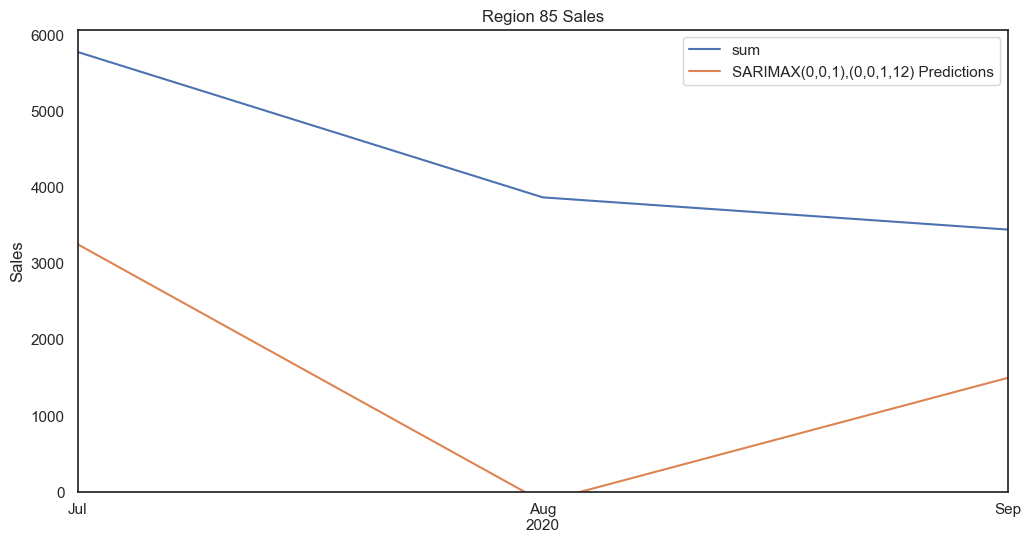

In [109]:
import matplotlib.pyplot as plt

title = 'Region 85 Sales'
ylabel='Sales'
xlabel=''  # we don't really need a label here

ax = test['num_orders'].plot(legend=True, figsize=(12, 6), title=title)
predictions.plot(legend=True, ax=ax)  # Make sure predictions plot on the same axis
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Set y-axis to start at zero
ax.set_ylim(bottom=0)  # This automatically adjusts the upper limit as needed

plt.show();

#### In-class Discussion
1) Would you recommend a top down, bottoms up, or hybrid approach of some sort? Why?
2) What other approaches should you take (other features and/or modeling approaches)?

## Optional undgraded exercise

- Use ML/AI to forecast sales for meal ID=1207
- Compare national level forecast to national level traditional model results based on MAPE
- Discuss which approach you would use and why?


In [110]:
list(sample.columns)

['center_id',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'id',
 'week',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'num_orders',
 'category',
 'cuisine',
 'month',
 'year',
 'discount',
 'Rolling Mean']

In [111]:
# Creating dummy variables

sample = pd.concat([sample,pd.get_dummies(sample['region_code'], prefix=None)],axis=1)
sample = pd.concat([sample,pd.get_dummies(sample['center_type'], prefix=None)],axis=1)

In [112]:
sample.head()

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,...,34,35,56,71,77,85,93,TYPE_A,TYPE_B,TYPE_C
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07,11,679,56,TYPE_A,3.7,1277077,1,1207,315.25,353.08,...,0,0,1,0,0,0,0,1,0,0
2018-01-14,11,679,56,TYPE_A,3.7,1106021,2,1207,322.04,323.04,...,0,0,1,0,0,0,0,1,0,0
2018-01-21,11,679,56,TYPE_A,3.7,1333188,3,1207,324.98,323.04,...,0,0,1,0,0,0,0,1,0,0
2018-01-28,11,679,56,TYPE_A,3.7,1268751,4,1207,318.16,319.16,...,0,0,1,0,0,0,0,1,0,0
2018-02-04,11,679,56,TYPE_A,3.7,1403388,5,1207,388.97,389.97,...,0,0,1,0,0,0,0,1,0,0


In [113]:
list(sample.columns)

['center_id',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'id',
 'week',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'num_orders',
 'category',
 'cuisine',
 'month',
 'year',
 'discount',
 'Rolling Mean',
 23,
 34,
 35,
 56,
 71,
 77,
 85,
 93,
 'TYPE_A',
 'TYPE_B',
 'TYPE_C']

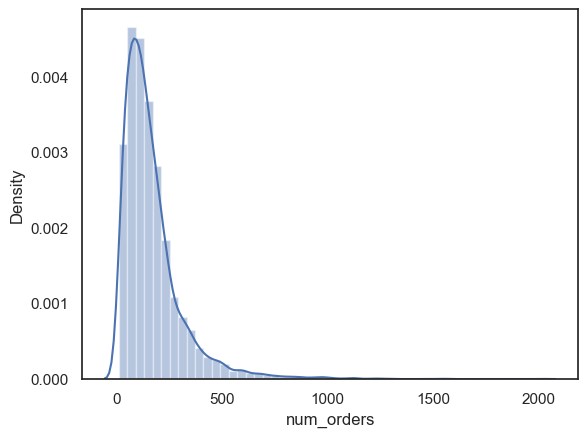

In [114]:
sns.distplot(sample.num_orders);

In [115]:
# Remove unwanted fields

sample.drop(['center_id',
 'city_code',
 'region_code',
 'center_type',
 'category',
 'cuisine',
 'id',
 'meal_id',
 'Rolling Mean',], axis=1, inplace=True) 

In [116]:
sample.sort_index(axis=0, inplace=True)
sample.head()

,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,month,year,discount,...,34,35,56,71,77,85,93,TYPE_A,TYPE_B,TYPE_C
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07,3.7,1,315.25,353.08,0,1,446,1,2018,-10.714286,...,0,0,1,0,0,0,0,1,0,0
2018-01-07,2.4,1,307.49,309.49,0,0,161,1,2018,-0.646224,...,0,0,0,0,1,0,0,1,0,0
2018-01-07,5.6,1,322.07,384.18,0,0,162,1,2018,-16.166901,...,0,0,1,0,0,0,0,0,1,0
2018-01-07,3.8,1,320.10,321.10,0,0,257,1,2018,-0.311429,...,0,0,0,0,1,0,0,1,0,0
2018-01-07,5.0,1,325.98,325.98,0,0,123,1,2018,0.000000,...,1,0,0,0,0,0,0,0,1,0


In [137]:
#train test split

train_size = int(len(sample) * 0.8)
train, test = sample[0:train_size], sample[train_size:len(sample)]
print(len(sample))
print(len(train))
print(len(test))

10653
8522
2131


In [138]:
# # Features Scaling

# # Features Scaling
#train = (train - train.mean()) / train.std()
#test = (test - test.mean()) / test.std()

X_train, y_train = train.drop(columns=["num_orders"], axis=1), train["num_orders"]
X_test, y_test = test.drop(columns=["num_orders"], axis=1), test["num_orders"]


In [139]:
# Train and test xgboost model

matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_test = xgb.DMatrix(X_test, label = y_test)

# Run XGB 
model = xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                ,dtrain = matrix_train, num_boost_round = 500, 
                early_stopping_rounds = 20, evals = [(matrix_test,'test')],)

[0]	test-mae:102.22997
[1]	test-mae:76.94629
[2]	test-mae:67.88600
[3]	test-mae:64.40969
[4]	test-mae:62.42712
[5]	test-mae:61.27660
[6]	test-mae:60.71019
[7]	test-mae:60.30144
[8]	test-mae:59.93821
[9]	test-mae:59.86407
[10]	test-mae:59.28853
[11]	test-mae:59.26558
[12]	test-mae:59.13359
[13]	test-mae:58.42177
[14]	test-mae:58.66081
[15]	test-mae:58.53373
[16]	test-mae:58.52219
[17]	test-mae:58.36824
[18]	test-mae:58.29309
[19]	test-mae:58.19199
[20]	test-mae:57.86463
[21]	test-mae:58.07378
[22]	test-mae:58.02043
[23]	test-mae:57.86645
[24]	test-mae:57.86490
[25]	test-mae:57.82634
[26]	test-mae:57.75572
[27]	test-mae:57.80415
[28]	test-mae:57.81663
[29]	test-mae:57.86825
[30]	test-mae:57.85929
[31]	test-mae:57.82613
[32]	test-mae:57.82528
[33]	test-mae:58.01569
[34]	test-mae:58.01956
[35]	test-mae:57.99066
[36]	test-mae:57.98694
[37]	test-mae:57.99826
[38]	test-mae:58.26478
[39]	test-mae:58.31590
[40]	test-mae:58.34648
[41]	test-mae:58.19881
[42]	test-mae:58.20554
[43]	test-mae:58.144

In [140]:
print(model.best_score)
print(model.best_iteration)
print("Best tree limit:", model.best_ntree_limit)

y_pred = model.predict(matrix_test, model.best_ntree_limit)

57.7557151911685
26
Best tree limit: 27


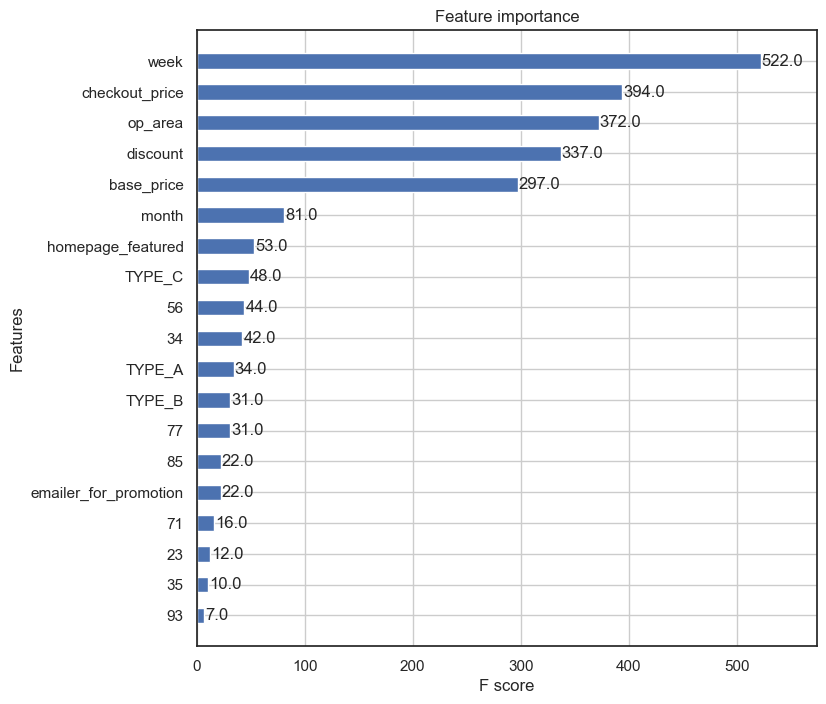

In [141]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, height=0.5, ax=ax);

In [142]:
test.sort_index(axis=0, inplace=True)
test.head()

,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,month,year,discount,...,34,35,56,71,77,85,93,TYPE_A,TYPE_B,TYPE_C
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-15,3.9,115,357.02,502.46,0,0,176,3,2020,-28.945588,...,0,0,1,0,0,0,0,0,0,1
2020-03-15,4.1,115,323.98,324.98,0,0,81,3,2020,-0.307711,...,0,0,0,0,0,0,1,1,0,0
2020-03-15,2.4,115,307.49,309.49,0,0,107,3,2020,-0.646224,...,0,0,0,0,1,0,0,1,0,0
2020-03-15,3.0,115,359.93,514.13,0,0,26,3,2020,-29.992414,...,0,0,0,0,0,1,0,1,0,0
2020-03-15,3.4,115,350.20,506.34,0,0,229,3,2020,-30.836987,...,0,0,0,0,0,0,0,1,0,0


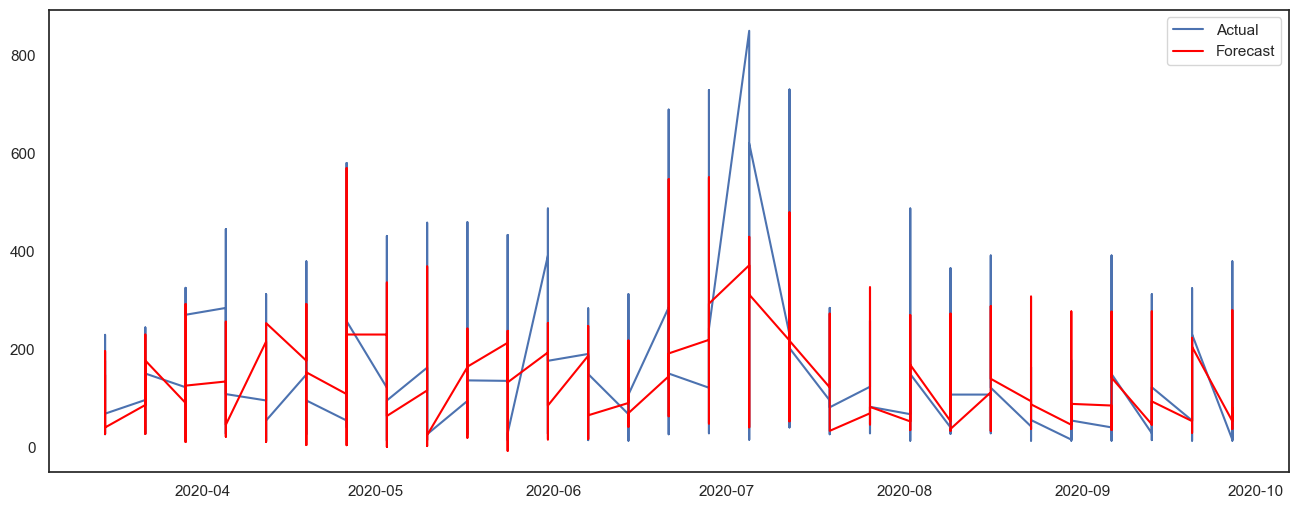

In [143]:
import random
df_pred = test.copy()
df_pred['Forecast'] = y_pred

plt.figure(figsize=(16, 6))
plt.plot(df_pred['num_orders'],label='Actual')
plt.plot(df_pred['Forecast'], 
         color='red', label='Forecast')
plt.legend();

In [146]:
from sklearn.metrics import mean_absolute_percentage_error

# Assuming you have a pandas DataFrame named 'data' with columns 'Date', 'Actual', and 'Forecast'

# Extract the actual and forecast values from the DataFrame
actual_values = df_pred['num_orders'].values
forecast_values = df_pred['Forecast'].values

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")

MAPE: 59.80%


2024-03-02 16:43:33,227 - INFO     - Executing shutdown due to inactivity...
2024-03-02 16:43:33,237 - INFO     - Executing shutdown...
2024-03-02 16:43:33,237 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [144]:
# Aggregating to monthly level to get same level of granularity with SARIMA model. 

monthly_gbt = df_pred.resample('MS')

monthly_gbt = monthly_gbt.agg({'num_orders': ['sum'],
                               'Forecast': ['sum']})

monthly_gbt.head()

,num_orders,Forecast
,sum,sum
Date,,
2020-03-01,20956,20021.636719
2020-04-01,45810,46542.523438
2020-05-01,50854,43741.882812
2020-06-01,58390,51658.042969
2020-07-01,57050,48119.226562


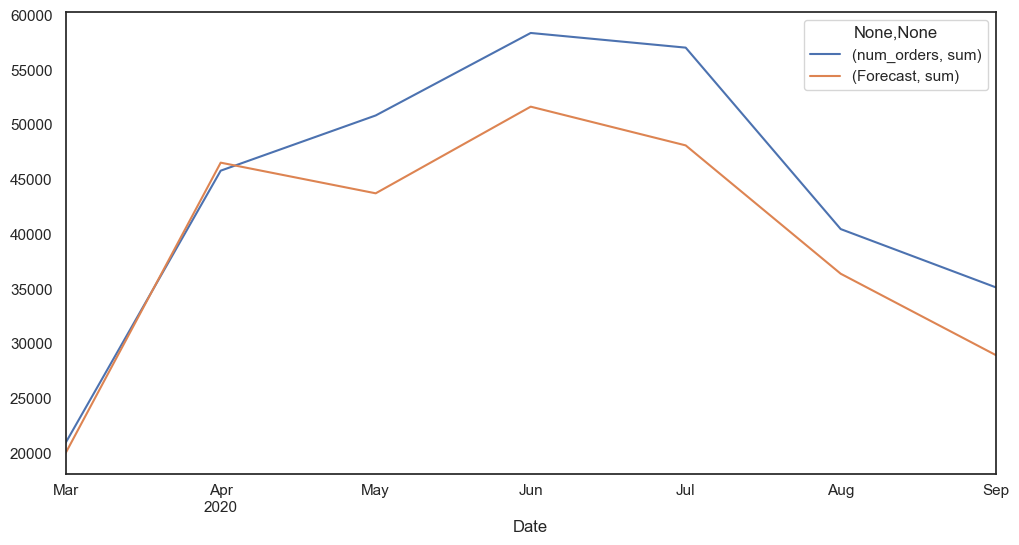

In [145]:
monthly_gbt[['num_orders','Forecast']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [126]:
# Rename the column to remove 'sum' from its name
monthly_gbt.rename(columns=lambda x: x.replace('sum', ''), inplace=True)

# Rename the column to remove 'first' from its name
monthly_gbt.rename(columns=lambda x: x.replace('first', ''), inplace=True)

monthly_gbt.head()

,num_orders,Forecast
,,
Date,,
2019-12-01,56164,67103.757812
2020-01-01,55927,47998.660156
2020-02-01,80003,84276.429688
2020-03-01,52039,58608.445312
2020-04-01,45810,56643.285156


In [127]:
from sklearn.metrics import mean_absolute_percentage_error

# Assuming you have a pandas DataFrame named 'data' with columns 'Date', 'Actual', and 'Forecast'

# Extract the actual and forecast values from the DataFrame
actual_values = monthly_gbt['num_orders'].values
forecast_values = monthly_gbt['Forecast'].values

# Calculate the MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(actual_values, forecast_values)
mape=mape*100

print(f"MAPE: {mape:.2f}%")

MAPE: 17.98%
